# Strava speed coefficients for travel time matrix computation

VH 23 January 2023,
updated VH 27 Jan 2023,
updated VH 17 Feb 2023,
updated CF 08 May 2024

Note the Terms of Use: https://metro.strava.com/terms
This report includes aggregated and de-identified data from Strava Metro.

Acquired for STYLE-project / Finnish Environment Institute Syke.

In [1]:
import pathlib

In [2]:
import geopandas
import matplotlib
import pandas

## Input data

In [3]:
DATA_DIRECTORY = pathlib.Path() / "data"

STRAVA_EDGES_DIRECTORY = (
    DATA_DIRECTORY / f"all_edges_monthly_2022-01-01-2022-12-31_ride/"
)
FILTER_TO_MONTH = "2022-09"

YKR_GRID_URL = (
    "/vsizip"
    "/vsicurl"
    "/https://zenodo.org/records/8325043/files"
    "/Helsinki_Travel_Time_Matrix_2023_grid.gpkg.zip"
)

OUTPUT_FILE = DATA_DIRECTORY / "all_edges_monthly_sep_2022_ride_speeds.gpkg"

### Strava attributes 

In [4]:
strava_speeds = pandas.read_csv(next(STRAVA_EDGES_DIRECTORY.glob("*.csv")))
strava_speeds = strava_speeds[strava_speeds.month == FILTER_TO_MONTH].reset_index(
    drop=True
)

strava_speeds

,edge_uid,activity_type,month,total_trip_count,forward_trip_count,reverse_trip_count,forward_people_count,reverse_people_count,forward_commute_trip_count,reverse_commute_trip_count,...,reverse_35_54_people_count,forward_55_64_people_count,reverse_55_64_people_count,forward_65_plus_people_count,reverse_65_plus_people_count,forward_average_speed,reverse_average_speed,osm_reference_id,ride_count,ebike_ride_count
0,202768525,"Ride,EBikeRide",2022-09,5,5,0,5,0,0,0,...,0,0,0,0,0,5.14,0.00,35407151,5,0
1,202778247,"Ride,EBikeRide",2022-09,10,5,5,5,5,0,0,...,5,0,0,0,0,4.25,6.43,279466944,10,0
2,202830112,"Ride,EBikeRide",2022-09,25,10,15,10,10,0,0,...,5,0,0,0,0,5.37,5.96,22516074,25,5
3,203039792,"Ride,EBikeRide",2022-09,25,15,15,10,10,5,5,...,10,0,0,0,0,8.53,7.49,70678694,25,0
4,203042445,"Ride,EBikeRide",2022-09,10,5,5,5,5,0,0,...,0,0,0,0,0,4.30,6.73,32458897,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272321,204028980,"Ride,EBikeRide",2022-09,80,30,45,30,30,0,0,...,25,0,0,0,0,0.98,1.83,825219879,55,25
272322,204031052,"Ride,EBikeRide",2022-09,35,15,15,15,15,0,0,...,15,0,0,0,0,7.00,6.21,22604919,35,0
272323,204036077,"Ride,EBikeRide",2022-09,25,15,15,10,10,0,0,...,5,0,0,0,0,12.25,7.49,22567566,25,0
272324,204185212,"Ride,EBikeRide",2022-09,5,0,5,0,5,0,0,...,5,0,0,0,0,0.00,50.86,188367069,5,0


### Strava geometries ('edges')

In [5]:
strava_geometries = geopandas.read_file(next(STRAVA_EDGES_DIRECTORY.glob("[!.]*.shp")))
strava_geometries

,edgeUID,osmId,geometry
0,202768486,49133119,"LINESTRING (22.95674 59.83004, 22.95692 59.83006)"
1,202769473,175477732,"LINESTRING (22.94245 59.84236, 22.94246 59.842..."
2,202771765,265103728,"LINESTRING (22.91994 59.91989, 22.92064 59.919..."
3,202773948,265105192,"LINESTRING (22.87333 59.94518, 22.86940 59.944..."
4,202822899,461373956,"LINESTRING (23.22928 59.85817, 23.22810 59.858..."
...,...,...,...
722936,203278172,34144203,"LINESTRING (24.94797 60.17228, 24.94787 60.172..."
722937,203536153,122750420,"LINESTRING (25.12530 60.20827, 25.12530 60.208..."
722938,203064325,463062288,"LINESTRING (24.37879 60.13730, 24.37881 60.137..."
722939,203295757,138732136,"LINESTRING (24.93983 60.19793, 24.93998 60.19795)"


### Extent of the study area 

In [6]:
ykr_grid_helsinki_metroregion = geopandas.read_file(YKR_GRID_URL)

matrix_extent = geopandas.GeoDataFrame(
    {
        "geometry": ykr_grid_helsinki_metroregion.dissolve().buffer(1000),
    },
    crs=ykr_grid_helsinki_metroregion.crs,
).to_crs("EPSG:4326")

matrix_extent

,geometry
0,"POLYGON ((24.48421 60.28002, 24.48388 60.28027..."


<Axes: >

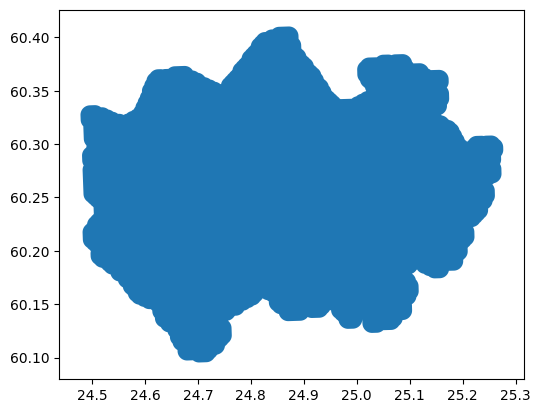

In [7]:
matrix_extent.plot()

## Pre-process data

### Filter strava geometries to study area

In [8]:
strava_geometries = strava_geometries.sjoin(
    matrix_extent,
    predicate="intersects",
).reset_index(drop=True)

strava_geometries

,edgeUID,osmId,geometry,index_right
0,203077714,8029707,"LINESTRING (24.50863 60.19191, 24.50974 60.19189)",0
1,203088644,473948072,"LINESTRING (24.49668 60.22334, 24.49683 60.22346)",0
2,203092562,6501336,"LINESTRING (24.53380 60.27045, 24.53467 60.270...",0
3,203104543,82678852,"LINESTRING (24.49290 60.32691, 24.49273 60.32686)",0
4,203111227,147042313,"LINESTRING (24.62711 60.15619, 24.62691 60.156...",0
...,...,...,...,...
505649,203198059,799469030,"LINESTRING (24.74374 60.24686, 24.74367 60.246...",0
505650,203278172,34144203,"LINESTRING (24.94797 60.17228, 24.94787 60.172...",0
505651,203536153,122750420,"LINESTRING (25.12530 60.20827, 25.12530 60.208...",0
505652,203295757,138732136,"LINESTRING (24.93983 60.19793, 24.93998 60.19795)",0


<Axes: >

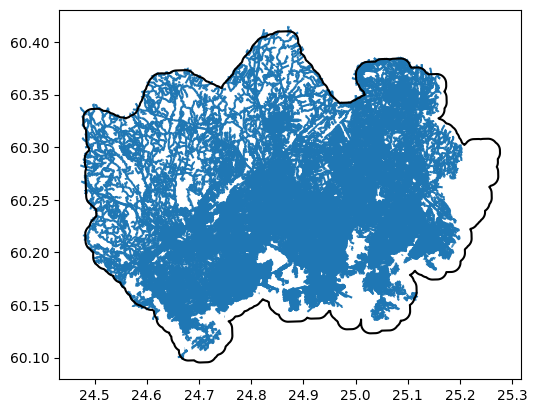

In [9]:
f, ax = matplotlib.pyplot.subplots()
strava_geometries.plot(ax=ax)
matrix_extent.boundary.plot(ax=ax, edgecolor="black")

### Join Strava attributes and geometries into one data set

In [10]:
strava_data = strava_geometries.merge(
    strava_speeds, left_on="edgeUID", right_on="edge_uid", how="left"
)
strava_data

,edgeUID,osmId,geometry,index_right,edge_uid,activity_type,month,total_trip_count,forward_trip_count,reverse_trip_count,...,reverse_35_54_people_count,forward_55_64_people_count,reverse_55_64_people_count,forward_65_plus_people_count,reverse_65_plus_people_count,forward_average_speed,reverse_average_speed,osm_reference_id,ride_count,ebike_ride_count
0,203077714,8029707,"LINESTRING (24.50863 60.19191, 24.50974 60.19189)",0,203077714.0,"Ride,EBikeRide",2022-09,100.0,50.0,50.0,...,25.0,0.0,5.0,0.0,0.0,4.60,9.25,8029707.0,95.0,5.0
1,203088644,473948072,"LINESTRING (24.49668 60.22334, 24.49683 60.22346)",0,203088644.0,"Ride,EBikeRide",2022-09,35.0,15.0,20.0,...,10.0,0.0,0.0,0.0,0.0,2.32,7.37,473948072.0,35.0,0.0
2,203092562,6501336,"LINESTRING (24.53380 60.27045, 24.53467 60.270...",0,203092562.0,"Ride,EBikeRide",2022-09,30.0,15.0,20.0,...,10.0,0.0,0.0,0.0,0.0,7.24,7.04,6501336.0,30.0,0.0
3,203104543,82678852,"LINESTRING (24.49290 60.32691, 24.49273 60.32686)",0,203104543.0,"Ride,EBikeRide",2022-09,30.0,10.0,20.0,...,10.0,0.0,0.0,0.0,0.0,1.41,0.74,82678852.0,30.0,0.0
4,203111227,147042313,"LINESTRING (24.62711 60.15619, 24.62691 60.156...",0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505649,203198059,799469030,"LINESTRING (24.74374 60.24686, 24.74367 60.246...",0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
505650,203278172,34144203,"LINESTRING (24.94797 60.17228, 24.94787 60.172...",0,203278172.0,"Ride,EBikeRide",2022-09,55.0,40.0,20.0,...,5.0,0.0,0.0,0.0,0.0,3.61,0.47,34144203.0,55.0,0.0
505651,203536153,122750420,"LINESTRING (25.12530 60.20827, 25.12530 60.208...",0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
505652,203295757,138732136,"LINESTRING (24.93983 60.19793, 24.93998 60.19795)",0,203295757.0,"Ride,EBikeRide",2022-09,20.0,10.0,10.0,...,5.0,0.0,0.0,0.0,0.0,5.64,4.18,138732136.0,20.0,0.0


### Compute an average speed between forward and reverse speeds


In [11]:
strava_data["speed"] = strava_data[
    ["forward_average_speed", "reverse_average_speed"]
].apply(lambda x: x.mean(), axis=1)

## Explore data

Not all edges seem to have speeds recorded in both directions

In [12]:
strava_data.forward_average_speed.isnull().value_counts()

forward_average_speed
True     297649
False    208005
Name: count, dtype: int64

In [13]:
strava_data.forward_average_speed.isnull().value_counts()

forward_average_speed
True     297649
False    208005
Name: count, dtype: int64

---

Some cyclists go at incredible speeds:<sup>*)</sup>

<Axes: >

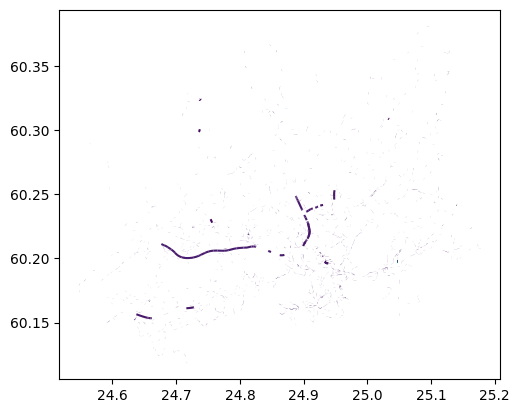

In [14]:
# faster than 20 m/s (54 km/h)
strava_data.loc[
    (strava_data["forward_average_speed"] > 20)
    | (strava_data["reverse_average_speed"] > 20)
].plot(column="forward_average_speed")

<sup>*)</sup> The two most prominent sets of edges in the plot above are motorway stretches on the way back to the city from the Nuuksio (west) and Siiponkorppi (north-east) national parks. Our working hypothesis is that riders forget to switch off Strava recording after cycling there.

---

Some edges have very few data points:

In [15]:
strava_data["edgeUID"].groupby(
    (strava_data["forward_people_count"] + strava_data["reverse_people_count"]) < 10
).count()

False    456049
True      49605
Name: edgeUID, dtype: int64

## Clean data

### Discard edges with a sample of fewer than 10 cyclists

In [16]:
strava_data = strava_data[
    (strava_data["forward_people_count"] + strava_data["reverse_people_count"]) >= 10
]
strava_data

,edgeUID,osmId,geometry,index_right,edge_uid,activity_type,month,total_trip_count,forward_trip_count,reverse_trip_count,...,forward_55_64_people_count,reverse_55_64_people_count,forward_65_plus_people_count,reverse_65_plus_people_count,forward_average_speed,reverse_average_speed,osm_reference_id,ride_count,ebike_ride_count,speed
0,203077714,8029707,"LINESTRING (24.50863 60.19191, 24.50974 60.19189)",0,203077714.0,"Ride,EBikeRide",2022-09,100.0,50.0,50.0,...,0.0,5.0,0.0,0.0,4.60,9.25,8029707.0,95.0,5.0,6.925
1,203088644,473948072,"LINESTRING (24.49668 60.22334, 24.49683 60.22346)",0,203088644.0,"Ride,EBikeRide",2022-09,35.0,15.0,20.0,...,0.0,0.0,0.0,0.0,2.32,7.37,473948072.0,35.0,0.0,4.845
2,203092562,6501336,"LINESTRING (24.53380 60.27045, 24.53467 60.270...",0,203092562.0,"Ride,EBikeRide",2022-09,30.0,15.0,20.0,...,0.0,0.0,0.0,0.0,7.24,7.04,6501336.0,30.0,0.0,7.140
3,203104543,82678852,"LINESTRING (24.49290 60.32691, 24.49273 60.32686)",0,203104543.0,"Ride,EBikeRide",2022-09,30.0,10.0,20.0,...,0.0,0.0,0.0,0.0,1.41,0.74,82678852.0,30.0,0.0,1.075
7,203123488,23359579,"LINESTRING (24.68033 60.16008, 24.68043 60.16010)",0,203123488.0,"Ride,EBikeRide",2022-09,5.0,5.0,5.0,...,0.0,0.0,0.0,0.0,4.13,5.35,23359579.0,5.0,0.0,4.740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505646,203273818,311381806,"LINESTRING (24.94271 60.17025, 24.94276 60.17026)",0,203273818.0,"Ride,EBikeRide",2022-09,55.0,25.0,30.0,...,0.0,0.0,0.0,0.0,2.68,3.99,311381806.0,50.0,5.0,3.335
505648,203299212,25618827,"LINESTRING (24.95104 60.20316, 24.95121 60.20319)",0,203299212.0,"Ride,EBikeRide",2022-09,25.0,10.0,10.0,...,0.0,0.0,0.0,0.0,6.33,6.99,25618827.0,25.0,0.0,6.660
505650,203278172,34144203,"LINESTRING (24.94797 60.17228, 24.94787 60.172...",0,203278172.0,"Ride,EBikeRide",2022-09,55.0,40.0,20.0,...,0.0,0.0,0.0,0.0,3.61,0.47,34144203.0,55.0,0.0,2.040
505652,203295757,138732136,"LINESTRING (24.93983 60.19793, 24.93998 60.19795)",0,203295757.0,"Ride,EBikeRide",2022-09,20.0,10.0,10.0,...,0.0,0.0,0.0,0.0,5.64,4.18,138732136.0,20.0,0.0,4.910


### Discard records with implausible speeds

In [17]:
strava_data["speed"].mean() * 3600 / 1000  # m/s -> km/h

18.207383409090916

In [18]:
strava_data["speed"].std()

2.9645574759880158

<Axes: >

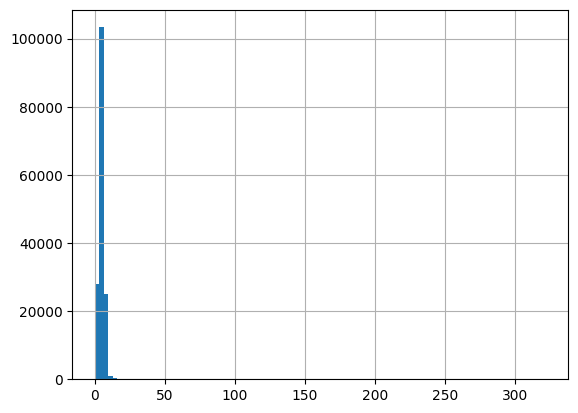

In [19]:
strava_data["speed"].hist(bins=100)

<Axes: >

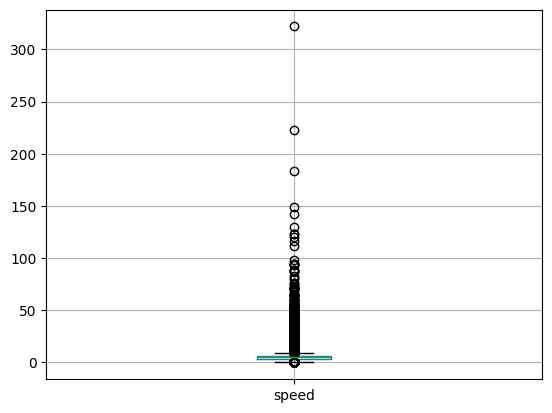

In [20]:
strava_data[["speed"]].boxplot()

In [21]:
cutoff = strava_data["speed"].mean() + 2 * strava_data["speed"].std()
cutoff

10.986721454501286

In [22]:
strava_data = strava_data[strava_data["speed"] < cutoff].reset_index(drop=True)

<Axes: >

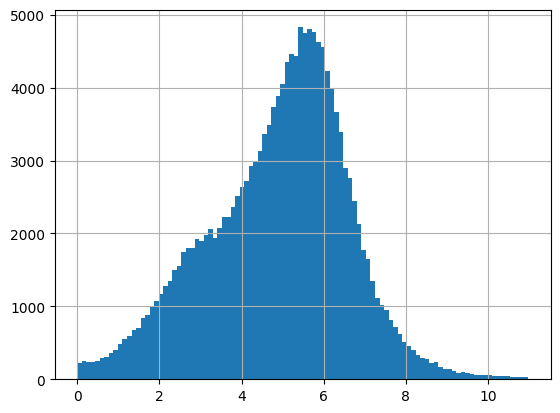

In [23]:
strava_data["speed"].hist(bins=100)

<Axes: >

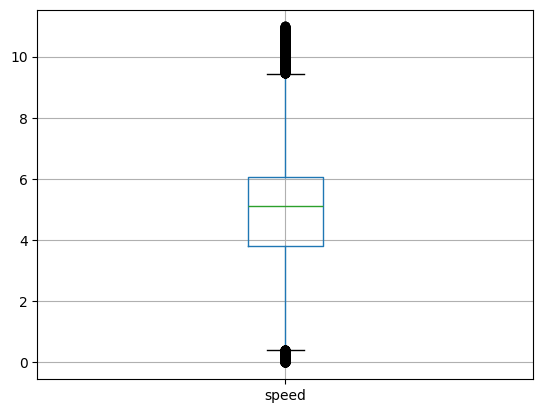

In [24]:
strava_data[["speed"]].boxplot()

### Keep only relevant columns

In [25]:
strava_data = strava_data[["edgeUID", "osmId", "geometry", "speed"]]

## Export data

In [26]:
strava_data.to_file(OUTPUT_FILE)